In [1]:
%matplotlib inline

import datajoint as dj
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_style('ticks', rc={'image.cmap': 'bwr'})

import os
import sys
import inspect

p = !pwd
p = os.path.dirname(os.path.dirname(p[0]))
if p not in sys.path:
    sys.path.append(p)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from cnn_sys_ident.mesonet.data import MultiDataset
from cnn_sys_ident.mesonet.vis import MEIParams, MEIGroup, MEI
from cnn_sys_ident.mesonet.parameters import Core, Readout, Model, RegPath, Fit
from cnn_sys_ident.architectures.training import Trainer
from cnn_sys_ident.mesonet import MODELS
from cnn_sys_ident.utils.mei import ActivityMaximization

Connecting aecker@52.202.15.166:3306


In [3]:
data_key = {'data_hash': 'cfcd208495d565ef66e7dff9f98764da'}
dataset = MultiDataset() & data_key

# Visualize MEIs for different cell types

In [4]:
num_filters = 16
model_rel = MODELS['HermiteSparse'] * dataset \
    & 'positive_feature_weights=False AND shared_biases=False' \
    & {'num_filters_2': num_filters}
key = (Fit() * model_rel).fetch(dj.key, order_by='val_loss', limit=1)[0]
num_rotations = (model_rel & key).fetch1('num_rotations')
model = Fit().load_model(key)

INFO:tensorflow:Restoring parameters from /gpfs01/bethge/home/aecker/lab/projects/microns/cnn-sys-ident/checkpoints/aecker_mesonet_data/647bb1d1bd02979996e492b5422eb95f/model.ckpt


In [5]:
masks = model.base.evaluate(model.readout.masks)
w = model.base.evaluate(model.readout.feature_weights)
w_norm = w / np.sqrt(np.sum(w ** 2, axis=1, keepdims=True))
w_marg = w_norm.reshape([-1, num_rotations, num_filters])
w_marg = np.sum(w_marg ** 2, axis=1)

print(masks.shape)
print(w.shape)
print(w_marg.shape)

(6005, 36, 64)
(6005, 128)
(6005, 16)


In [6]:
trainer = Trainer(model.base, model)
r = trainer.compute_val_corr()
print(r.mean())

0.219424180611875


In [7]:
dj.conn()

DataJoint connection (connected) aecker@52.202.15.166:3306

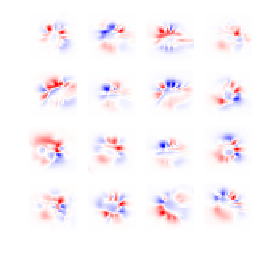

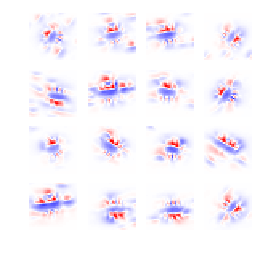

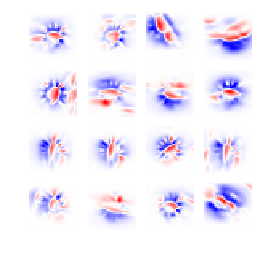

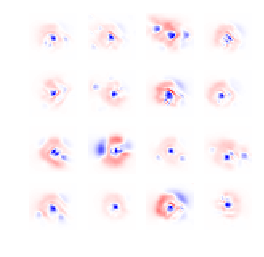

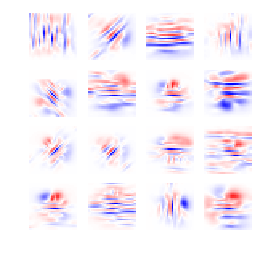

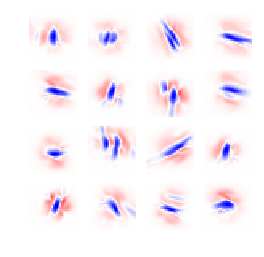

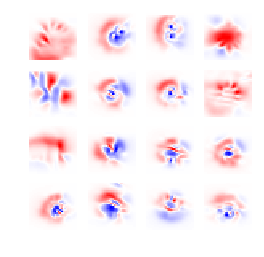

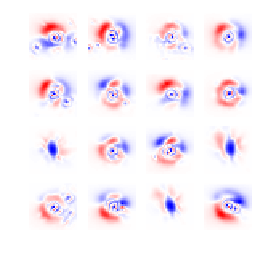

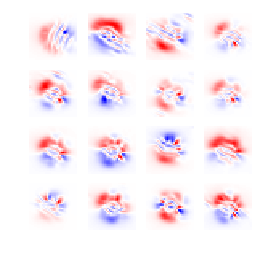

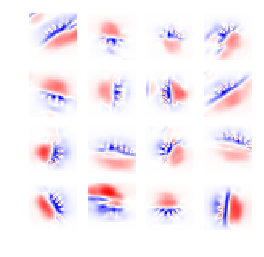

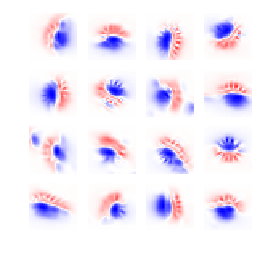

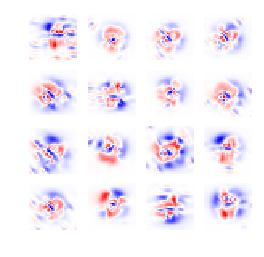

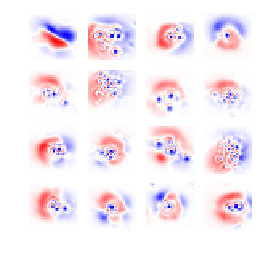

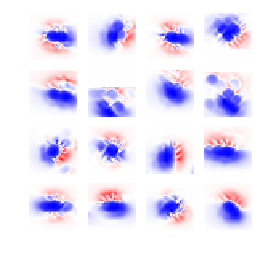

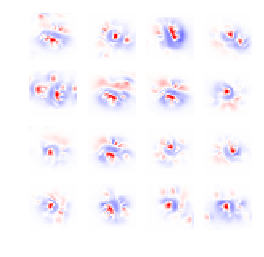

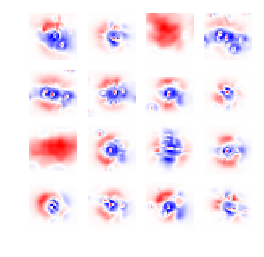

In [10]:
min_corr = 0.2
k = 15   # x2
n_x = masks.shape[2] + 2*k
n = [1, 15]
type_id = np.argmax(np.abs(w_marg), axis=1)
for i in range(num_filters):
    idx, = np.where((type_id == i) & (r > min_corr))
    order = np.argsort(-w_marg[idx,i])
    fig, axes = plt.subplots(n[0], n[1], figsize=(n[1], n[0]))
    for unit_id, ax in zip(idx[order], axes.flatten()):
        key = {'unit_id': unit_id, 'param_id': 1}
        rel = MEI() & key
        if len(rel):
            img = rel.fetch1('max_image')
            img = np.pad(img, k, 'constant')
            m = np.abs(img).max() + 1e-3
            mask = np.pad(masks[unit_id], k, 'constant')
            rf_idx = mask.argmax()
            rf_i, rf_j = rf_idx // n_x, rf_idx % n_x
            img  = img[rf_i-k:rf_i+k,rf_j-k:rf_j+k]
            ax.imshow(img, vmin=-m, vmax=m)
        ax.axis('off')
#     fig.suptitle('Type {}'.format(i+1))
    fig.savefig('figures/meis_4x4{:d}.eps'.format(i+1), format='eps')

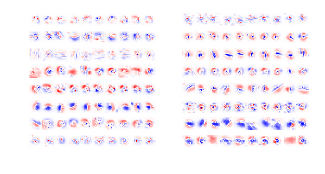

In [23]:
min_corr = 0.2
k = 15   # x2
n_x = masks.shape[2] + 2*k
n = 10
type_id = np.argmax(np.abs(w_marg), axis=1)
fig, axes = plt.subplots(num_filters // 2, 2, figsize=(5, 2.5))
for i, ax in enumerate(axes.flatten()):
    idx, = np.where((type_id == i) & (r > min_corr))
    order = np.argsort(-w_marg[idx,i])
    imgs = []
    for unit_id in idx[order[:10]]:
        key = {'unit_id': unit_id, 'param_id': 1}
        rel = MEI() & key
        if len(rel):
            img = rel.fetch1('max_image')
            img = np.pad(img, k, 'constant')
            m = np.abs(img).max() + 1e-3
            mask = np.pad(masks[unit_id], k, 'constant')
            rf_idx = mask.argmax()
            rf_i, rf_j = rf_idx // n_x, rf_idx % n_x
            img  = img[rf_i-k:rf_i+k,rf_j-k:rf_j+k]
            imgs.append(img)
        
    img = np.concatenate(imgs, axis=1)
    ax.imshow(img, vmin=-m, vmax=m)
    ax.axis('off')

fig.savefig('figures/meis.eps', format='eps')